In [5]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import os
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2
from skimage import io, transform
import matplotlib.pyplot as plt
import random
import cv2

In [ ]:
# dowload the dataset from google drive 
! gdown --id 1CX3x0YmRmDQivhjfgB0kVzfXzVql7Axj

# unzip the dataset 
!unzip /content/stage1_train.zip

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
## Access to the google drive
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [8]:
class Nuclie_data(Dataset):
        def __init__(self,path):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_transforms(0.5, 0.5)
        
        def __len__(self):
            return len(self.folders)
              
        
        def __getitem__(self,idx):
            image_folder = os.path.join(self.path,self.folders[idx],'images/')
            mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
            image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
            
            #convert the RGBA into RGB
            img = io.imread(image_path)[:,:,:3].astype('float32')
            img = transform.resize(img,(128,128))

            masks=[]
            for mskName in os.listdir(mask_folder):
                vesMask = (cv2.imread(mask_folder+'/'+mskName, 0) > 0).astype(np.uint8)  # Read vesse instance mask
                vesMask=cv2.resize(vesMask,[128,128],cv2.INTER_NEAREST)
                masks.append(vesMask)
            
            #mask = get_mask(mask_folder, 128, 128 ).astype('float32')
            boxes = get_bounding_box(mask_folder, 128, 128 )
          
            # convert everything into a torch.Tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            masks = torch.as_tensor(masks, dtype=torch.float32)
            #img = torch.as_tensor(img, dtype=torch.float32)
            image_id = torch.tensor([idx])
            
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            
            #augmentation
            augmented = self.transforms(image=img)
            img = augmented['image']
            #mask = augmented['mask']
            num_objs = len(boxes)
            
            # suppose all instances are not crow
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
            
            target = {}
            target["boxes"] = boxes 

            #there is only one class 
            target["labels"] =  torch.ones((num_objs,), dtype=torch.int64)   # there is only one class
            target["masks"] = masks
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd
            
            return (img,target) 

In [9]:
##get the bounding box for each individual mask 
def get_bounding_box(mask_folder,IMG_HEIGHT, IMG_WIDTH):
    boxes = []
    #masks = []
    for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder,mask_)).astype('float32')
            mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
            ###get the bounding box
            pos = np.where(mask_)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
            #masks.append(mask_)
              
    return boxes

In [10]:
def get_transforms(mean, std):
            list_transforms = []
            
            list_transforms.extend(
                    [
                HorizontalFlip(p=0), # only horizontal flip as of now
                    ])
            list_transforms.extend(
                    [
            Normalize(mean=mean, std=std, p=1),
            ToTensorV2(),
                    ])
            list_trfms = Compose(list_transforms)
            return list_trfms

In [11]:
#loading the datad
data_dir = '/content/stage1_train/'
data = Nuclie_data(data_dir)

In [12]:
#data size
print(data.__len__())

670


In [14]:
def plot_box(img, box):

    colors = (255, 0, 0)
    thickness = 1
    
    for idx in range(len(box)):
        tmp_box = box[idx]
        x_min = tmp_box[0]
        y_min = tmp_box[1]
        x_max = tmp_box[2]
        y_max = tmp_box[3]
        start_point = (int(x_min), int(y_min))
        end_point = (int(x_max), int(y_max))
        if idx == 0:
           plt_box = cv2.rectangle(image_convert(img), start_point, end_point, colors, thickness)
        else:
           plt_box = cv2.rectangle(plt_box, start_point, end_point, colors, thickness)

    return plt_box

In [15]:
# converting tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image

In [ ]:
def combined_mask(masks,IMG_HEIGHT, IMG_WIDTH):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    masks = masks.clone().cpu().detach().numpy()
    for idx in range(len(masks)):
            mask_ = masks[idx]
            mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
            mask_ = np.expand_dims(mask_,axis=-1)
            mask = np.maximum(mask, mask_)
              
    return mask

In [16]:
img, target = data.__getitem__(345)

<ipython-input-8-95a83ea7e777>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  masks = torch.as_tensor(masks, dtype=torch.float32)


<ipython-input-13-404582ac3bec>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


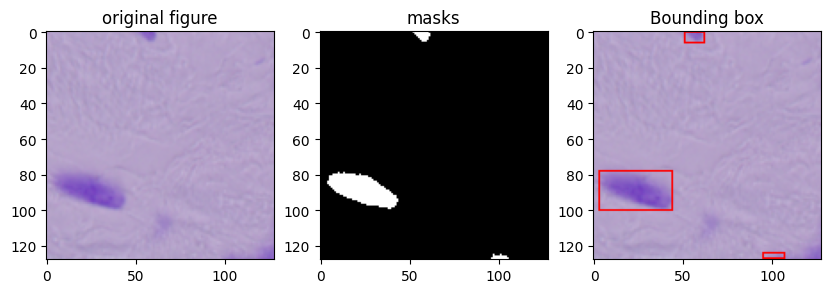

In [17]:
plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
plt.title('original figure')
plt.imshow(image_convert(img))

plt.subplot(1,3,2)
plt.title('masks')
plt.imshow(combined_mask(target['masks'], 128, 128), cmap='gray')


plt.subplot(1,3,3)
plt.title('Bounding box')
plt.imshow(plot_box(img, target['boxes']))

In [18]:
import torchvision.models.segmentation
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [54]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(2)
model.to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-5,
                            momentum=0.9, weight_decay=0.0005)
model.train()

In [57]:
##### parameters setting #####
train_set = 580
batch_sizes = 1
iteration = 1001
outdir = "/content/MyDrive/MyDrive/trained_model/"
##############################

loss_epoch = []
for i in range(iteration):       
    
    #how many batches used in each iteration 
    for b in range(batch_sizes):
        images = []
        targets = []
        idx=random.randint(0,train_set-1)
        image_, target_ = data.__getitem__(idx)
        images.append(image_)
        targets.append(target_)

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
    print(f"start iteration {i}")
    optimizer.zero_grad()
    loss_dict = model(images, targets)

    losses = sum(loss for loss in loss_dict.values())
    losses.backward()
    optimizer.step()
    print(i,'loss:', losses.item())
    loss_epoch.append(losses.item())
    #save model for every 100 iteration 
    if i%100==0:
       torch.save(model.state_dict(), os.path.join(outdir,str(i)+"individal_mask.torch"))

start iteration 0
0 loss: 6.08594274520874
start iteration 1
1 loss: 6.396068096160889
start iteration 2
2 loss: 9.58297348022461
start iteration 3
3 loss: 4.995846748352051
start iteration 4
4 loss: 5.195674419403076
start iteration 5
5 loss: 5.059649467468262
start iteration 6
6 loss: 3.3856201171875
start iteration 7
7 loss: 3.6944217681884766
start iteration 8
8 loss: 3.3372693061828613
start iteration 9
9 loss: 2.963318109512329
start iteration 10
10 loss: 4.938662052154541
start iteration 11
11 loss: 3.10658597946167
start iteration 12
12 loss: 3.078798532485962
start iteration 13
13 loss: 3.362231969833374
start iteration 14
14 loss: 3.4284794330596924
start iteration 15
15 loss: 2.632056951522827
start iteration 16
16 loss: 2.611971616744995
start iteration 17
17 loss: 2.2252390384674072
start iteration 18
18 loss: 2.9692301750183105
start iteration 19
19 loss: 3.0978684425354004
start iteration 20
20 loss: 2.8358545303344727
start iteration 21
21 loss: 5.308004379272461
start 

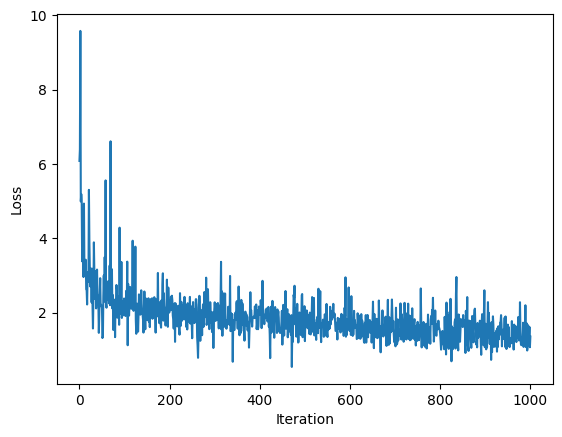

In [58]:
# Plot loss
plt.plot(list(range(len(loss_epoch))), loss_epoch)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
#load the pre-trained model 
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) 
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#load your model and set the model to evaluation state
model.load_state_dict(torch.load("/content/MyDrive/MyDrive/trained_model/19individal_mask.torch"))
model.eval()

In [ ]:
model.eval()

In [ ]:
model.to(device)# move model to the right device

In [28]:
def get_predicted_box(pred, cutoff = 0.8):
    
    filtered_box = []
    for i in range(len(pred[0]['boxes'])):
        box=pred[0]['boxes'][i].detach().cpu().numpy()
        scr=pred[0]['scores'][i].detach().cpu().numpy()
        if scr > cutoff :
           filtered_box.append(box)
    return filtered_box

In [169]:
def get_predicted_masks(image, pred, IMG_HEIGHT = 128, IMG_WIDTH = 128, cutoff = 0.7):
    
    ig = imag.detach().cpu().numpy()
    im2 =ig.copy()
    im2 = im2.transpose((1,2,0))
    for i in range(len(pred[0]['masks'])):
        scr=pred[0]['scores'][i].detach().cpu().numpy()
        if scr > 0.5 :   
           msk=pred[0]['masks'][i,0].detach().cpu().numpy()
           im2[:,:,0][msk>0.5] = random.randint(0,255)
           im2[:, :,1][msk > 0.5] = random.randint(0,255)
           im2[:, :,2][msk > 0.5] = random.randint(0,255)
    return im2.astype(np.uint8)

In [92]:
### get one testing image 
imag, mak = data.__getitem__(644)
img = []
img.append(imag)
img = list(image.to(device) for image in img)

In [62]:
# testing the model 
with torch.no_grad():
    pred = model(img)

In [70]:
## get all of predicted boxes 
pred_box = get_predicted_box(pred, cutoff = 0.85)
p_0 = plot_box(imag, pred_box)

<ipython-input-13-404582ac3bec>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


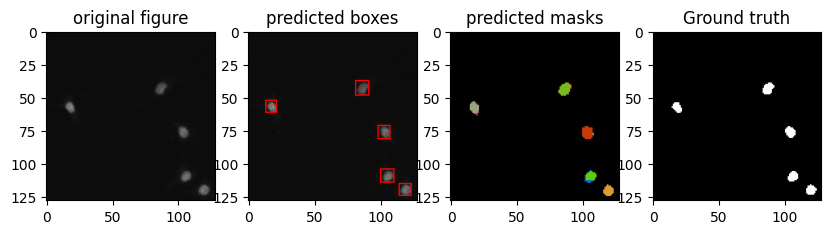

In [170]:
plt.figure(figsize=(10,6))
plt.subplot(1,4,1)
plt.title('original figure')
plt.imshow(image_convert(imag))

plt.subplot(1,4,2)
plt.title('predicted boxes')
plt.imshow(p_0)

plt.subplot(1,4,3)
plt.title('predicted masks')
plt.imshow(get_predicted_masks(imag, pred, cutoff = 0.5))

plt.subplot(1,4,4)
plt.title('Ground truth')
plt.imshow(combined_mask(mak['masks'], 128,128), cmap='gray')